Data source: https://drive.google.com/file/d/1dzWxfv6C_0tb0vt45JgW2nj8bWiDJW4K/view?usp=sharing

### imports and performance metric

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold,cross_validate, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,make_scorer

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from typing import Dict, Optional

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso

In [ ]:
df=pd.read_csv("train.csv")
submissiondf=pd.read_csv("test.csv")
products=pd.read_excel("Urun Ozellikleri.xlsx")
submisson=pd.read_csv("sample_submission.csv")

<ipython-input-15-d74824f4edd0>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("train.csv")
<ipython-input-15-d74824f4edd0>:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  submissiondf=pd.read_csv("test.csv")


In [ ]:
# Script of coeffs
def determine_coeffs(filename: str) -> Dict[str, float]:
    df = pd.read_csv(filename)
    label_counts = df.groupby('LABEL').size()
    inverse_freq: Dict[str, float] = {k: 1 / v for k, v in label_counts.items()}
    normalized_coeffs: Dict[str, float] = {k: v / sum(inverse_freq.values()) for k, v in inverse_freq.items()}
    return normalized_coeffs

if __name__ == "__main__":
    coeffs = determine_coeffs('train.csv')
    if coeffs:
        print("Normalized Coefficients:")
        for label, coeff in coeffs.items():
            print(f"{label}: {coeff}")

<ipython-input-16-1be0362cb9f7>:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


Normalized Coefficients:
HU06: 0.038554833858603386
HU07: 0.032866754829034756
HU11: 0.27910538041604
HU12: 0.1812533461577538
HU14: 0.011393645341514
HU15: 0.2952464144641965
HU19: 0.1614324927571035
UA: 0.00014713217575397958


In [ ]:
weights=[coeffs["UA"],coeffs["HU14"],coeffs["HU07"],coeffs["HU06"],coeffs["HU19"],coeffs["HU12"],coeffs["HU11"],coeffs["HU15"]]

In [ ]:
def weighted_f1_score(preds, dmat):
    labels = dmat.get_label()
    y_pred = np.argmax(preds, axis=1)
    weightedf1 = weighted_f1_score(labels, y_pred, weights)
    return "custom", weightedf1

In [ ]:
def calcWeightedf1(y_pred,y_test,weights):
    weightedf1= f1_score(y_test, y_pred,average=None).dot(weights)
    return weightedf1

### Examining the tables

In [ ]:
products.head(5)

,Ürün,Branş,Grup/Ferdi,Kredili/Kredisiz,Taşınan Teminat,Biriktiren/ Koruma,Sigortas Süresi,Yenileme Fonksiyonu,Yaş Gereksinimi
0,BU01,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
1,BU02,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,18-25
2,BU03,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
3,BU04,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
4,BU05,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN


In [ ]:
df.describe()

,PP_CINSIYET,PP_YAS,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_RG,SORU_EGITIM_RG,SORU_GELIR_RG,SORU_COCUK_SAYISI_CVP,SORU_COCUK_SAYISI_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
count,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,46874.000000,301775.00000,256913.000000,203418.000000,154799.000000,154799.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,319.000000,319.000000,1976.000000,1976.000000,5334.000000,5334.000000,302407.000000,3.024070e+05,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000,302407.000000
mean,1.494380,440.413165,104.737642,1.007668,30.504674,28.230298,87.43437,84.877328,103.359609,0.104943,142.058037,0.010502,0.000360,0.000526,0.002245,1162.981403,683.911159,898.801093,603.271111,873.190290,595.990070,872.272583,596.008770,757.782353,526.185545,625.952084,439.361440,589.570003,411.324212,520.954674,367.906325,476.044529,335.815464,439.100686,307.293568,417.640091,291.991293,407.756775,283.859666,607.586207,1.059561,4370.481781,1.688765,7133.025309,2.825459,17444.258198,3.316258e+04,0.046682,0.093748,0.006858,0.000754,0.000321,0.000007,0.005255,0.096023,0.173095,0.044106,0.079089,0.000007,0.049493,0.000334,0.000966,0.119584,0.200012,0.008793,0.049156,0.026015,0.004471,0.001088,0.179685,0.031517,0.000344,0.000023,0.000741,0.011084,0.009633,0.016478,0.006733,0.005264,0.002315,0.000913,0.000083,0.020297,0.000724,0.000403,0.012824,0.020324,0.006425,63.028472
std,0.499969,204.528075,1.427831,0.110661,18.959024,11.959561,69.22631,71.155770,63.322374,0.481671,52.021119,0.116929,0.021126,0.027028,0.093177,4193.618128,3150.402859,1316.330614,1218.070139,1262.055884,1176.185213,1287.624075,1168.711874,1136.448180,1066.851458,998.772842,942.497675,1011.376767,930.589805,869.292170,829.729743,771.795151,729.334113,726.663648,694.563521,657.498653,629.375902,679.352369,648.186411,4148.694053,0.419150,12475.716164,3.651502,16657.961949,6.328001,39512.429755,1.121339e+05,0.212286,0.305428,0.085907,0.029199,0.019156,0.002572,0.076042,0.315752,0.449423,0.217333,0.312868,0.002572,0.246951,0.019834,0.032617,0.369880,0.462696,0.098460,0.267174,0.166450,0.069339,0.034820,0.400369,0.181543,0.027696,0.004811,0.033523,0.104887,0.138119,0.145009,0.081776,0.079174,0.051894,0.032108,0.009092,0.150871,0.026901,0.022119,0.165253,0.141806,0.095923,56.579096
min,1.000000,1.000000,101.000000,1.000000

In [ ]:
df["MUSTERI_ID"].duplicated().sum()

0

No dublicated customer

In [ ]:
df.isnull().sum()[lambda x: x > 0]

PP_MESLEK                      3673
SORU_YATIRIM_KARAKTERI_CVP    28955
SORU_YATIRIM_KARAKTERI_RG     28955
SORU_MEDENI_HAL_CVP              69
SORU_MEDENI_HAL_RG               69
SORU_EGITIM_CVP                5159
SORU_EGITIM_RG                 5159
SORU_GELIR_CVP                11161
SORU_GELIR_RG                 11161
SORU_COCUK_SAYISI_CVP         16761
SORU_COCUK_SAYISI_RG          16761
SON_AY_KATKI_MIKTARI          34270
SON_AY_KATKI_ADET             34270
SON_CEYREK_KATKI_MIKTARI      34067
SON_CEYREK_KATKI_ADET         34067
SON_SENE_KATKI_MIKTARI        33701
SON_SENE_KATKI_ADET           33701
HU14                              1
HU15                              1
HU16                              1
HU17                              1
HU18                              1
HU19                              1
AKTIF_ILK_POLICE_RG               1
dtype: int64

 "SORU_YATIRIM_KARAKTERI" and features related to "KATKI" are mostly empty. "SORU_COCUK_SAYISI_CVP" has half of the rows empty while "SORU_GELIR", "SORU_EGITIM" and "PP_MESLEK" also has high amouth of null rows.

In [ ]:
df["LABEL"].value_counts()

LABEL
UA      832770
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: count, dtype: int64

In [ ]:
(df["LABEL"].value_counts()[0]/len(df))*100

97.66054233575187

97.6% of the products are UA, which does'nt match with any of the products

### EDA

In [ ]:
df_wpolicies=df[df["LABEL"]!="UA"]

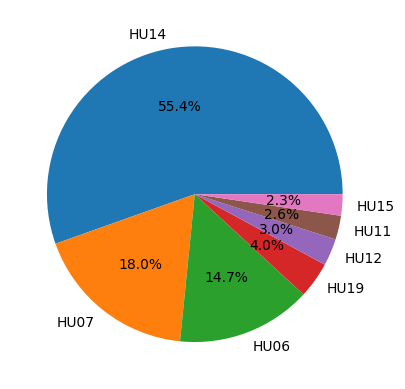

In [ ]:
policy_valuecounts = pd.DataFrame(df_wpolicies["LABEL"].value_counts().reset_index());
plt.pie(data=policy_valuecounts,x='LABEL',labels='index', autopct='%.1f%%');

In [ ]:
policy_df=pd.DataFrame(index=df["LABEL"].unique().tolist())
for policy in policies:
  policy_df_new=df[df[policy]!=0]["LABEL"].value_counts(normalize=True).mul(100).round(1)
  policy_df=pd.concat([policy_df, policy_df_new],axis=1).rename(columns={"LABEL":policy})
policy_df.fillna(0,inplace=True)

In [ ]:
policy_df

,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19
UA,98.5,96.5,98.5,97.2,100.0,100.0,99.6,97.3,95.7,98.8,98.8,0.0,97.5,91.7,97.1,95.6,96.8,97.4,94.8,99.8,99.5,95.7,99.7,98.4,100.0,0.0,93.3,97.1,91.0,92.2,97.0,92.0,83.8,83.7,83.3,88.7,42.9,89.5,85.3,94.3,92.6
HU19,0.1,0.2,0.3,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1.2,0.0,0.0,3.0,4.7,0.0,1.1,0.0,0.0,2.8,0.0,0.8
HU07,0.1,0.8,0.0,0.0,0.0,0.0,0.0,1.4,0.4,0.0,0.2,0.0,0.2,0.0,2.9,0.9,0.6,0.3,0.2,0.1,0.0,0.0,0.0,0.4,0.0,0.0,3.3,0.2,1.7,0.7,0.0,0.9,0.0,0.0,0.0,1.2,0.0,0.0,0.0,1.4,1.2
HU14,0.9,2.3,0.6,0.0,0.0,0.0,0.0,1.1,2.6,0.6,0.3,0.0,1.6,0.0,0.0,2.4,1.9,0.8,2.8,0.1,0.5,2.1,0.0,1.0,0.0,0.0,0.0,0.6,1.7,4.4,2.1,5.7,12.1,2.3,0.0,5.5,2.9,0.0,7.3,2.2,3.7
HU11,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.6,0.3,0.0,0.0,2.3,0.0,1.0,0.0,0.0,1.2,0.2,0.0
HU15,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.3,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,0.2,0.9,0.0,0.0,0.5,0.0,0.0,0.0,0.2,54.3,0.0,0.0,0.2,0.0
HU12,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.5,0.0,7.0,16.7,0.5,0.0,0.0,1.4,0.0,0.8
HU06,0.1,0.2,0.6,2.8,0.0,0.0,0.4,0.2,0.7,0.5,0.3,0.0,0.5,8.3,0.0,0.6,0.3,1.6,1.3,0.0,0.0,2.1,0.3,0.1,0.0,0.0,0.0,1.6,4.3,0.9,0.6,0.5,1.0,0.0,0.0,1.8,0.0,10.5,1.9,1.6,0.8


There are few instances of really high correlation compared to other relations. <br> 54.3% of the customers with HU15 policy purchase HU15 policy again.
<br> 8.3% of the customers with BU14 policy purchase U06 policy
<br> 12.1% of the customers with HU11 policy purchase HU14 policy
<br> 10.5% of the customers with HU16 policy purchase HU06 policy
<br> 7.3% of the customers with HU17 policy purchase HU14 policy
<br> <br>  Each customer in the dataset had at least one policy already purchased


In [ ]:
max_values =df.groupby("LABEL")[policies].mean().max(axis=1)
max_value_cols =df.groupby("LABEL")[policies].mean().idxmax(axis=1)
pd.concat([max_value_cols,max_values*100],axis=1).rename(columns={0:"Previous Popular Policy",1:"Share of Previous Policy"})

,Previous Popular Policy,Share of Previous Policy
LABEL,,
HU06,BU09,37.804878
HU07,BU08,30.500000
HU11,BU09,58.620690
HU12,BU09,69.696970
HU14,BU09,34.846029
HU15,HU15,73.076923
HU19,HU17,43.181818
UA,BU17,19.872525


<Axes: xlabel='LABEL', ylabel='count'>

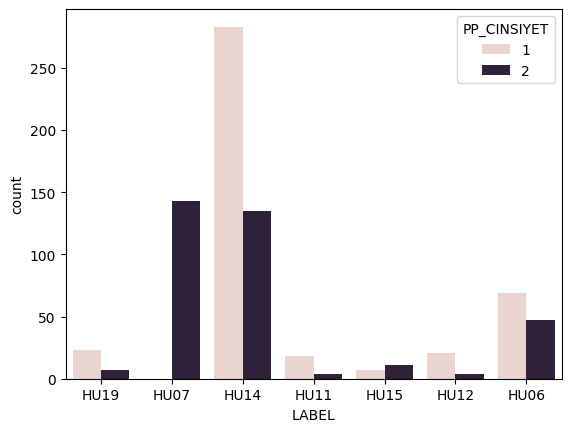

In [ ]:
sns.countplot(data=df_wpolicies, x="LABEL",hue="PP_CINSIYET")

In [ ]:
ordered_months=["MAYIS","HAZIRAN","TEMMUZ","AGUSTOS","EYLUL","EKIM"]

<Axes: xlabel='FLAG'>

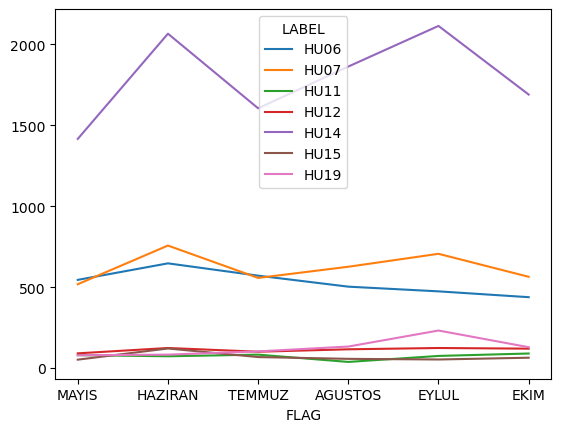

In [ ]:
pd.pivot_table(data=df_wpolicies,values="MUSTERI_ID", columns="LABEL",index="FLAG",aggfunc="count").reindex(ordered_months).plot()

In [ ]:
pivot_age=pd.pivot_table(data=df_wpolicies,values="MUSTERI_ID", columns="LABEL",index="PP_YAS",aggfunc="count").fillna(0)

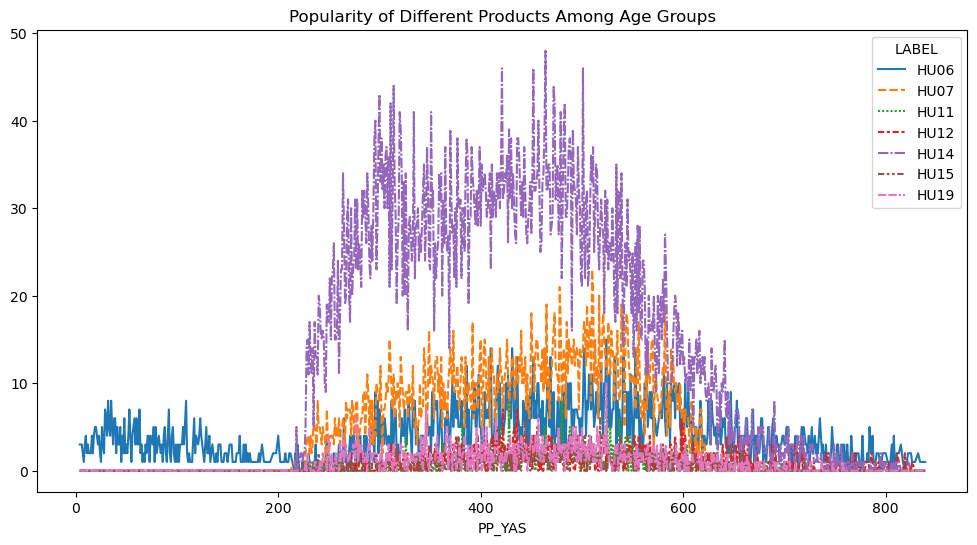

In [ ]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(pivot_age);
#plt.legend()
plt.title("Popularity of Different Products Among Age Groups");

<Axes: xlabel='PP_MUSTERI_SEGMENTI', ylabel='count'>

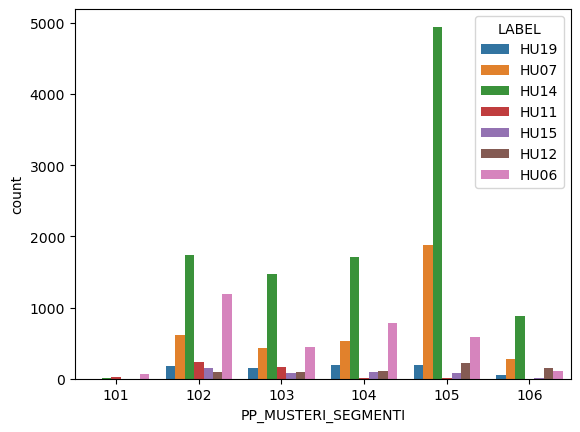

In [ ]:
sns.countplot(data=df_wpolicies,x="PP_MUSTERI_SEGMENTI",hue="LABEL")

In [ ]:
df['PP_MESLEK'].value_counts().head(20).index

Index(['İşçi', 'Öğrenci', 'Ev Hanımı', 'Diğer', 'Öğretmen', 'Esnaf', 'Memur',
       'Serbest Meslek', 'Mühendis',
       'Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)', 'Danışman',
       'SSK-Sosyal Sigortalar Kurumu Emeklileri', 'Emekli', 'Akademisyen',
       'Banka', 'Tacir ve Esnaf', 'Ordu Mensubu', 'Hekim', 'Çiftçi',
       'Hemşire'],
      dtype='object')

<Axes: xlabel='SORU_MEDENI_HAL_CVP', ylabel='count'>

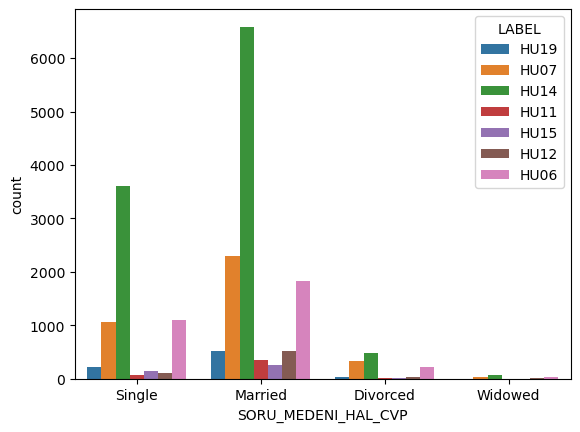

In [ ]:
sns.countplot(data=df_wpolicies,x="SORU_MEDENI_HAL_CVP",hue="LABEL")

In [ ]:
df[["SORU_YATIRIM_KARAKTERI_RG","SORU_MEDENI_HAL_RG","SORU_EGITIM_RG","SORU_GELIR_RG","SORU_COCUK_SAYISI_RG"]]

,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_RG,SORU_EGITIM_RG,SORU_GELIR_RG,SORU_COCUK_SAYISI_RG
0,NaN,68.0,68.0,NaN,NaN
1,NaN,11.0,11.0,11.0,NaN
2,26.0,235.0,235.0,NaN,235.0
3,NaN,111.0,111.0,111.0,111.0
4,NaN,91.0,91.0,91.0,91.0
...,...,...,...,...,...
852714,NaN,9.0,9.0,NaN,NaN
852715,NaN,53.0,53.0,53.0,NaN
852716,NaN,234.0,234.0,234.0,234.0
852717,NaN,74.0,74.0,74.0,NaN


When people answered the survey they usually answered all of the questions at the same time.

In [ ]:
odeme=["ODEME_TUTAR_0","ODEME_TUTAR_1","ODEME_TUTAR_2","ODEME_TUTAR_3","ODEME_TUTAR_4","ODEME_TUTAR_5","ODEME_TUTAR_6","ODEME_TUTAR_7","ODEME_TUTAR_8","ODEME_TUTAR_9","ODEME_TUTAR_10","ODEME_TUTAR_11"]
vade=["VADE_TUTAR_0","VADE_TUTAR_1","VADE_TUTAR_2","VADE_TUTAR_3","VADE_TUTAR_4","VADE_TUTAR_5","VADE_TUTAR_6","VADE_TUTAR_7","VADE_TUTAR_8","VADE_TUTAR_9","VADE_TUTAR_10","VADE_TUTAR_11"]

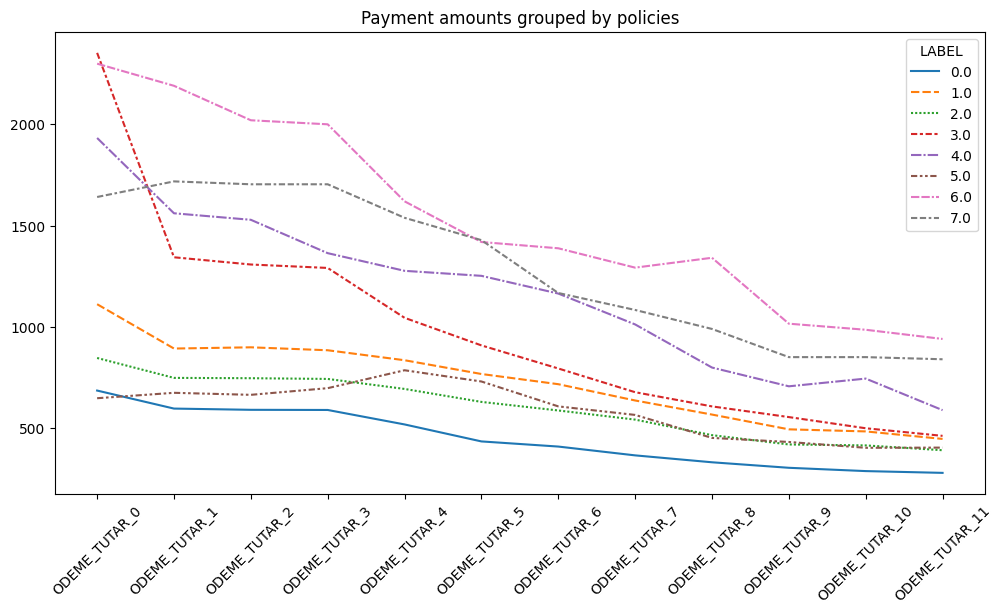

In [ ]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(df.groupby("LABEL").mean()[odeme].T);
plt.xticks(rotation=45)
plt.title("Payment amounts grouped by policies");

In [ ]:
df_mean=df.groupby("LABEL")[odeme].mean()
df_mean["state"]="mean"
df_max=df.groupby("LABEL")[odeme].max()
df_max["state"]="max"
df_payment=pd.concat([df_mean,df_max],axis=0)
df_payment.reset_index(inplace=True)
df_payment=df_payment.set_index(["LABEL","state"]).sort_index()

In [ ]:
df_payment

ODEME_TUTAR_0  ODEME_TUTAR_1  ODEME_TUTAR_2  ODEME_TUTAR_3  \
LABEL state                                                               
HU06  max      6699.000000    5742.000000    5742.000000    5742.000000   
      mean     1221.145161    1289.806452    1159.854839    1069.806452   
HU07  max      9570.000000    9570.000000    9570.000000    9570.000000   
      mean      633.635417     646.989583     615.041667     631.635417   
HU11  max      7665.000000    7665.000000    7665.000000    7665.000000   
      mean     2091.500000    1666.875000    1779.937500    1739.812500   
HU12  max      1921.000000    1921.000000    1921.000000    1921.000000   
      mean      577.428571     577.428571     577.428571     666.214286   
HU14  max      9570.000000    9570.000000    9570.000000    8410.000000   
      mean      837.223048     884.446097     891.869888     878.059480   
HU15  max      7923.000000    7923.000000    7923.000000    7923.000000   
      mean     1920.300000    2013.100000    2013.100000    2013.100000   
HU19  max      7070.000000    8664.000000    8664.000000    8329.000000   
      mean     1861.352941    2042.647059    2059.294118    2003.294118   
UA    max    191400.000000   53352.000000   36873.000000   26843.000000   
      mean      710.155828     599.054723     589.273332     583.878467   

             ODEME_TUTAR_4  ODEME_TUTAR_5  ODEME_TUTAR_6  ODEME_TUTAR_7  \
LABEL state                                                               
HU06  max      5742.000000    3700.000000    3649.000000    3692.000000   
      mean      975.467742     794.225806     714.661290     627.016129   
HU07  max      1822.000000    1822.000000    1588.000000    5490.000000   
      mean      522.614583     452.958333     411.666667     440.145833   
HU11  max      4306.000000    4153.000000    4153.000000    4153.000000   
      mean     1321.750000    1089.500000    1275.125000    1056.625000   
HU12  max      1921.000000    1921.000000    1921.000000    1921.000000   
      mean      555.071429     581.000000     447.142857     430.714286   
HU14  max      8410.000000    8410.000000    8812.000000    7656.000000   
      mean      845.695167     763.710037     704.078067     645.684015   
HU15  max      5100.000000    5072.000000    4287.000000    4287.000000   
      mean     1730.800000    1615.000000    1249.800000    1249.800000   
HU19  max      8329.000000    8329.000000    8329.000000    8329.000000   
      mean     2003.294118    1719.705882    1664.176471    1208.705882   
UA    max     33495.000000   27321.000000   47850.000000   76560.000000   
      mean      523.092907     422.909670     399.846601     375.609802   

             ODEME_TUTAR_8  ODEME_TUTAR_9  ODEME_TUTAR_10  ODEME_TUTAR_11  
LABEL state                                                                
HU06  max      2838.000000    2827.000000     2827.000000     2827.000000  
      mean      595.096774     526.741935      523.500000      492.112903  
HU07  max      1540.000000    1153.000000     1153.000000     1153.000000  
      mean      354.489583     321.062500      321.062500      314.395833  
HU11  max      6220.000000    4153.000000     4153.000000     4153.000000  
      mean     1415.500000     908.437500      848.625000      848.625000  
HU12  max      1037.000000    2277.000000     1037.000000     1037.000000  
      mean      332.071429     422.642857      260.000000      264.785714  
HU14  max      4555.000000    4555.000000     4555.000000     3780.000000  
      mean      572.237918     466.319703      461.130112      425.691450  
HU15  max      4287.000000    4287.000000     4287.000000     4287.000000  
      mean     1206.800000    1066.200000     1066.200000     1066.200000  
HU19  max      5014.000000    5014.000000     5014.000000     5014.000000  
      mean     1003.470588     966.000000      829.235294      674.470588  
UA    max     19140.000000   57420.000000    21341.000000    57420.000000  
      mean      342

<Axes: ylabel='LABEL-state'>

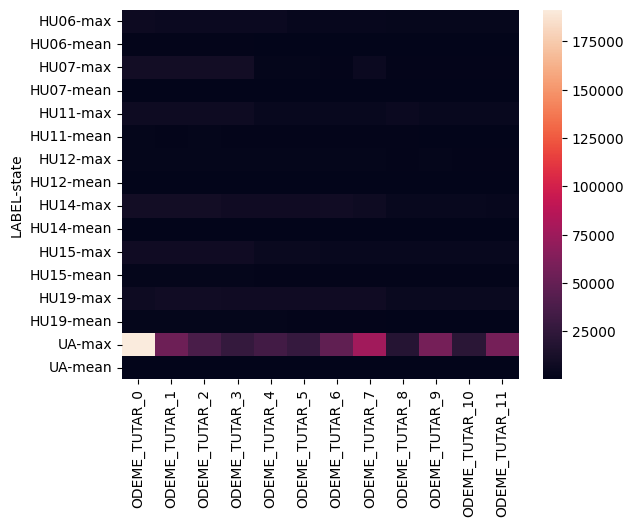

In [ ]:
sns.heatmap(df_payment)

There is two rows with label "HU06" where "ODEME_TUTAR_0" and "VADE_TUTAR_0" are really high compared to other rows with the same label while other payments are 0. I decided to remove these customers because it seems like they are outliers with single really high payment.

In [ ]:
df.drop(index=[14286,13818],inplace=True)
df.reindex()

In [ ]:
def create_paymentdf(category):
  df_grouped=df[df["LABEL"]==category][odeme]
  df_grouped =df_grouped.agg(['mean', 'std', 'count']).T
  df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
  df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
  df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
  df_grouped['Period'] = df_grouped.index
  df_grouped['Label']=label
  return df_grouped

In [ ]:
paymentdf=pd.DataFrame()
for label in df["LABEL"].unique():
  df_grouped=create_paymentdf("UA")
  paymentdf=pd.concat([paymentdf,df_grouped],axis=0)
paymentdf

,mean,std,count,ci,ci_lower,ci_upper,Period,Label
ODEME_TUTAR_0,674.748577,3129.520796,832769.0,6.721584,668.026993,681.470161,ODEME_TUTAR_0,UA
ODEME_TUTAR_1,592.724601,1185.388815,832769.0,2.545978,590.178623,595.270579,ODEME_TUTAR_1,UA
ODEME_TUTAR_2,586.493693,1166.697189,832769.0,2.505832,583.987861,588.999525,ODEME_TUTAR_2,UA
ODEME_TUTAR_3,586.456768,1160.764631,832769.0,2.493090,583.963678,588.949858,ODEME_TUTAR_3,UA
ODEME_TUTAR_4,517.723360,1064.797707,832769.0,2.286972,515.436388,520.010333,ODEME_TUTAR_4,UA
...,...,...,...,...,...,...,...,...
ODEME_TUTAR_7,361.277295,803.737722,832769.0,1.726268,359.551028,363.003563,ODEME_TUTAR_7,HU06
ODEME_TUTAR_8,329.797608,725.564152,832769.0,1.558367,328.239241,331.355974,ODEME_TUTAR_8,HU06
ODEME_TUTAR_9,301.980930,682.579061,832769.0,1.466043,300.514887,303.446973,ODEME_TUTAR_9,HU06
ODEME_TUTAR_10,287.159085,638.346391,832769.0,1.371040,285.788045,288.530125,ODEME_TUTAR_10,HU06


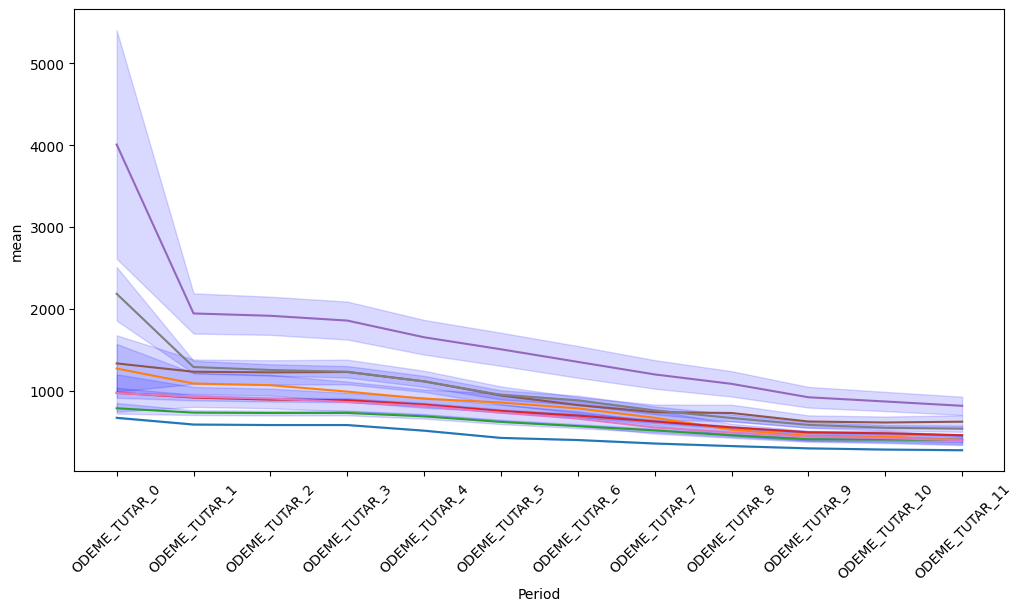

In [ ]:
fig = plt.figure(figsize = (12,6))
for label in df["LABEL"].unique():
  df_grouped=create_paymentdf(label)
  ax = sns.lineplot(data=df_grouped, x="Period" ,y='mean');
  ax.fill_between(
    df_grouped["Period"], df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15);
plt.xticks(rotation=45);


<ipython-input-200-aa4f4450a243>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

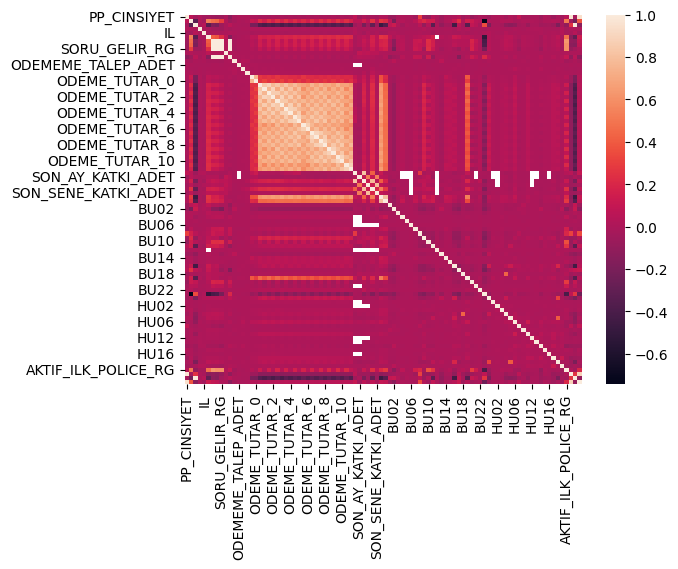

In [ ]:
sns.heatmap(df.corr())

### Preparing the Features

In [ ]:
df=pd.concat([df,submissiondf],axis=0)

In [ ]:
## crossed features
df["CINSIYET_YAS"]=df["PP_CINSIYET"]*100+df["PP_YAS"].apply(lambda x:int(x/12))
df["SEGMENT_YAS"]=(df["PP_MUSTERI_SEGMENTI"]%10)*100+df["PP_YAS"].apply(lambda x:int(x/12))
df["CINSIYET_SEGMENT"]=df["PP_CINSIYET"]*10 + df["PP_MUSTERI_SEGMENTI"]

In [ ]:
policies=["BU01","BU02","BU03","BU04","BU05","BU06","BU07","BU08","BU09","BU10","BU11","BU12","BU13","BU14","BU15","BU16","BU17","BU18","BU19","BU20","BU21","BU22","BU23","BU24","HU01","HU02","HU03","HU04","HU05","HU06","HU07","HU10","HU11","HU12","HU13","HU14","HU15","HU16","HU17","HU18","HU19"]

In [ ]:
df_meslek=df_wpolicies.groupby('PP_MESLEK')[policies].mean()
popular_by_meslek=df_meslek.idxmax(axis=1)

In [ ]:
popular_by_il=df_wpolicies.groupby('IL')[policies].mean().idxmax(axis=1)
frequency_by_il=df_wpolicies.groupby('IL').count()['MUSTERI_ID']

In [ ]:
df.drop(["SORU_YATIRIM_KARAKTERI_CVP","SORU_MEDENI_HAL_CVP","SORU_EGITIM_CVP","SORU_GELIR_CVP","SORU_COCUK_SAYISI_CVP",
             "SORU_YATIRIM_KARAKTERI_RG","SORU_MEDENI_HAL_RG","SORU_EGITIM_RG","SORU_GELIR_RG","SORU_COCUK_SAYISI_RG",
             "SON_AY_KATKI_MIKTARI","SON_AY_KATKI_ADET","SON_CEYREK_KATKI_MIKTARI","SON_CEYREK_KATKI_ADET","SON_SENE_KATKI_MIKTARI","SON_SENE_KATKI_ADET"],axis=1,inplace=True)
df.drop("FLAG",axis=1,inplace=True)

In [ ]:
odeme=["ODEME_TUTAR_0","ODEME_TUTAR_1","ODEME_TUTAR_2","ODEME_TUTAR_3","ODEME_TUTAR_4","ODEME_TUTAR_5","ODEME_TUTAR_6","ODEME_TUTAR_7","ODEME_TUTAR_8","ODEME_TUTAR_9","ODEME_TUTAR_10","ODEME_TUTAR_11"]
vade=["VADE_TUTAR_0","VADE_TUTAR_1","VADE_TUTAR_2","VADE_TUTAR_3","VADE_TUTAR_4","VADE_TUTAR_5","VADE_TUTAR_6","VADE_TUTAR_7","VADE_TUTAR_8","VADE_TUTAR_9","VADE_TUTAR_10","VADE_TUTAR_11"]

In [ ]:
df['Vade Ortalama']=df[vade].mean(axis=1)
df['Ödeme Ortalama']=df[odeme].mean(axis=1)
df['Ödeme std']=df[odeme].std(axis=1)

In [ ]:
payment_difference=pd.DataFrame()
for i in np.arange(12):
    month_str = f"Month_{i+1}"
    payment_difference[month_str]=df[vade[i]]-df[odeme[i]]
payment_difference["Payment Difference Mean"]=payment_difference.mean(axis=1)
payment_difference["MUSTERI_ID"]=df["MUSTERI_ID"]
df=df.merge(payment_difference[["Payment Difference Mean","MUSTERI_ID"]],how="left",on="MUSTERI_ID")

In [ ]:

df=df.merge(popular_by_meslek.to_frame('Popularity_by_meslek'),how="left",on="PP_MESLEK")
df=df.merge(popular_by_il.to_frame('Popularity_by_il'),how="left",on="IL")
df=df.merge(frequency_by_il.to_frame('frequency_by_il'),how="left",on="IL")
df["Negatfi Talep"]=df["BES_AYRILMA_TALEP_ADET"]+df["ODEMEME_TALEP_ADET"]+df["HAYAT_AYRILMA_TALEP_ADET"]

In [ ]:
df["Previous Policies"]=df[["BU01","BU02","BU03","BU04","BU05","BU06","BU07","BU08","BU09","BU10","BU11","BU12","BU13","BU14","BU15","BU16","BU17","BU18","BU19","BU20","BU21","BU22","BU23","BU24","HU01","HU02","HU03","HU04","HU05","HU06","HU07","HU10","HU11","HU12","HU13","HU14","HU15","HU16","HU17","HU18","HU19"]].sum(axis=1)

In [ ]:
df['LABEL'] = df['LABEL'].map({'UA':0, 'HU14':1, 'HU07':2, 'HU06':3, 'HU19':4,'HU12':5, 'HU11':6, 'HU15':7 })
df['Popularity_by_meslek'] = df['Popularity_by_meslek'].map({'BU01':1, 'BU02':2,'BU08':3,'BU09':4,'BU13':5, 'BU16':6, 'BU17':7,'BU18':8,'BU19':9,'BU24':10,'HU06':11, 'HU12':12, 'HU14':13, 'HU17':14, 'HU19':15}).fillna(0)
df['Popularity_by_il'] = df['Popularity_by_il'].map({'BU01':1, 'BU02':2,'BU08':3,'BU09':4,'BU13':5, 'BU16':6, 'BU17':7,'BU18':8,'BU19':9,'BU24':10,'HU06':11, 'HU12':12, 'HU14':13, 'HU17':14, 'HU19':15})

In [ ]:
df.drop("PP_MESLEK",axis=1,inplace=True)

### ürün özellikleri

In [ ]:
products=pd.read_excel("Urun Ozellikleri.xlsx")

In [ ]:
products.set_index("Ürün ",inplace=True)
products = pd.get_dummies(products, columns=['Branş '], prefix='',dtype=int)
products = pd.get_dummies(products, columns=['Grup/Ferdi'], prefix='',dtype=int)
products = pd.get_dummies(products, columns=['Kredili/Kredisiz'], prefix='',dtype=int)
products["Taşınan Teminat"]=products["Taşınan Teminat"].isna().map({True:0,False:1})
products = pd.get_dummies(products, columns=['Biriktiren/ Koruma'], prefix='',dtype=int)
products = pd.get_dummies(products, columns=["Sigortas Süresi "], prefix='',dtype=int)
products = pd.get_dummies(products, columns=['Yenileme Fonksiyonu '], prefix='',dtype=int)
products["Yaş Gereksinimi"]=products["Yaş Gereksinimi"].isna().map({True:0,False:1})

In [ ]:
df['HU08']=0
df['HU09']=0
policy_names=["BU01","BU02","BU03","BU04","BU05","BU06","BU07","BU08","BU09","BU10","BU11","BU12","BU13","BU14","BU15","BU16","BU17","BU18","BU19","BU20","BU21","BU22","BU23","BU24","HU01","HU02","HU03","HU04","HU05","HU06","HU07",'HU08','HU09',"HU10","HU11","HU12","HU13","HU14","HU15","HU16","HU17","HU18","HU19"]
df=pd.concat([df,df[policy_names].dot(products) ], axis=1)
df.drop(['HU08','HU09'],axis=1,inplace=True)

In [ ]:
df.set_index("MUSTERI_ID",inplace=True)

#### Gathering the previous policies in two column

In [ ]:
policy_df=df[policies].copy()
for  policy in policies:
  policy_df[policy]=policy_df[policy].map({1:policy,0:""})

In [ ]:
policy_dict=dict(zip(policies,np.arange(1,len(policies)+1)))

In [ ]:
df['Products Purchased_1'] = policy_df[policies].apply(lambda x: ''.join(x.dropna()), axis=1)
df['Products Purchased_2']=df['Products Purchased_1'].apply(lambda x:x[4:8])
df['Products Purchased_3']=df['Products Purchased_1'].apply(lambda x:x[8:12])
df['Products Purchased_1']=df['Products Purchased_1'].apply(lambda x:x[:4])

In [ ]:
df["Products Purchased_1"]=df["Products Purchased_1"].map(policy_dict).fillna(0)
df["Products Purchased_2"]=df["Products Purchased_2"].map(policy_dict).fillna(0)
df["Products Purchased_3"]=df["Products Purchased_3"].map(policy_dict).fillna(0)

In [ ]:
#Separate train dataframefrom submission data frame
submissiondf=df[df["LABEL"].isna()]
train_df=df[df["LABEL"].notna()]

In [ ]:
train_df

,LABEL,PP_CINSIYET,PP_YAS,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,CINSIYET_YAS,SEGMENT_YAS,CINSIYET_SEGMENT,Vade Ortalama,Ödeme Ortalama,Ödeme std,Payment Difference Mean,Popularity_by_meslek,Popularity_by_il,frequency_by_il,Negatfi Talep,Previous Policies,Taşınan Teminat,Yaş Gereksinimi,_Bireysel Emeklilik,_Hayat Sigortası,_otomatik Katılım,_Ferdi,_Grup,_Kredi Bağlantılı,_Krediden bağımsız,_Biriktiren,_Koruma,_Kredi süresi ile uyumlu,_Uzun Süreli,_Yıllık,_Tercih doğrultusunda yenilenir,_evet,_hayır,Products Purchased_1,Products Purchased_2,Products Purchased_3
MUSTERI_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34ba975819dd9907482e7,0.0,2,505,105,1,34.0,0,0,0,0,405,405,405,405,405,405,405,405,405,405,220,220,220,220,220,220,220,220,220,220,0,0,0,0,2654,132,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,242,542,125,260.416667,260.416667,150.249162,0.000000,6.0,4.0,4327.0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1.0,0.0,0.0
8cd400d3897e5ff130e8e942ee1906d17531a8253d26a466b2ad97023bfd5bfd,0.0,2,889,102,1,20.0,0,0,0,0,5720,5720,5720,5720,4763,4763,4763,4763,4763,4763,2871,2871,2871,2871,2871,2871,2871,2871,957,957,1914,3828,0,0,62945,75370,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,274,274,122,3340.333333,3499.833333,1785.021102,-159.500000,7.0,4.0,359.0,0,2,0,0,2,0,0,2,0,0,2,2,0,0,2,0,0,0,0,9.0,19.0,0.0
6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad744bdb43e9419b875f,4.0,2,578,104,1,6.0,0,0,0,0,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,631,631,631,631,631,631,631,631,631,631,631,631,631,631,22929,16055,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,66,248,448,124,856.416667,856.416667,278.576400,0.000000,4.0,7.0,2080.0,0,3,1,1,2,1,0,3,0,0,3,2,1,0,2,1,1,0,0,9.0,17.0,34.0
fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e4fa8e4300ed5303ef5,0.0,2,648,106,1,34.0,0,0,0,0,574,0,574,0,574,0,574,0,306,0,306,0,306,0,306,0,306,0,306,0,306,0,306,0,178,497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,254,654,126,395.333333,0.000000,0.000000,395.333333,7.0,4.0,4327.0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,17.0,0.0,0.0
aae8411e2c335e94922290314abe1fcc81044e8071e1c85fe77c4e13b000d491,0.0,2,487,103,1,77.0,0,0,0,0,459,0,459,0,459,0,459,459,459,459,459,459,459,0,459,0,248,0,248,0,248,0,248,0,1378,1151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,240,340,123,388.666667,114.750000,207.590561,273.916667,7.0,4.0,83.0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,16.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4a245f1a49af39319faa41668d6ee425fb71c7a75e8b22fab2f39be5ecd76739,0.0,1,551,105,1,35.0,0,0,0,0,430,430,430,430,430,430,0,0,1914,1914,1914,1914,1914,1914,1914,1914,1914,1914,0,0,0,0,0,0,10295,1816,0,0,0,0,0,0,0,0,0,0,0,0,

### Corelation

<ipython-input-106-0ab9eca9a44c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation=df.corr()["LABEL"].drop("LABEL")


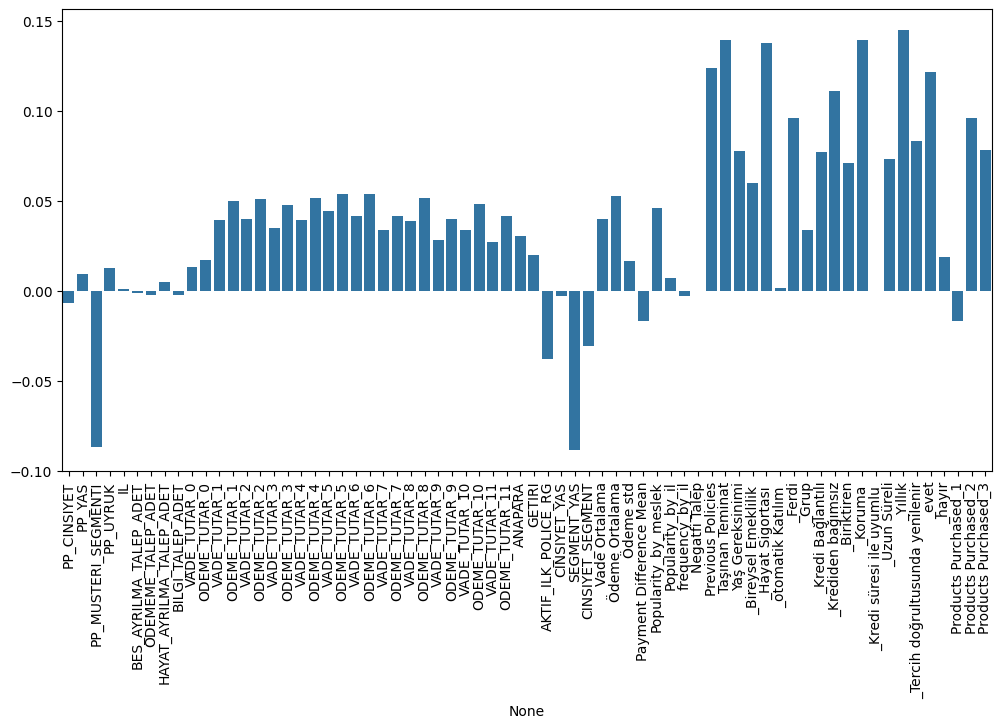

In [ ]:
correlation=train_df.corr()["LABEL"].drop("LABEL")
fig = plt.figure(figsize = (12,6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.xticks(rotation=90);

### first model

In [ ]:
X = train_df.drop('LABEL', axis=1)
y = train_df['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

,PP_CINSIYET,PP_YAS,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG,CINSIYET_YAS,SEGMENT_YAS,CINSIYET_SEGMENT,Vade Ortalama,Ödeme Ortalama,Ödeme std,Payment Difference Mean,Popularity_by_meslek,Popularity_by_il,frequency_by_il,Negatfi Talep,Previous Policies,Taşınan Teminat,Yaş Gereksinimi,_Bireysel Emeklilik,_Hayat Sigortası,_otomatik Katılım,_Ferdi,_Grup,_Kredi Bağlantılı,_Krediden bağımsız,_Biriktiren,_Koruma,_Kredi süresi ile uyumlu,_Uzun Süreli,_Yıllık,_Tercih doğrultusunda yenilenir,_evet,_hayır,Products Purchased_1,Products Purchased_2,Products Purchased_3
MUSTERI_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2509b2f37ce687faebc41d9cab2b07d9499fa85cbdede7bba90865fa59c7f3c2,1,488,102,1,34.0,0,0,0,0,449,449,449,449,449,449,449,449,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,8986,7619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,45,140,240,112,309.000000,309.000000,103.396852,0.000000,1.0,4.0,4327.0,0,2,0,1,1,1,0,0,2,0,2,2,0,0,2,0,0,0,0,16.0,40.0,0.0
53acf25e3f0f619d3320c90674bdd758b1c9ac4bf19d9a89768e8fc3370c6b0d,2,140,106,1,67.0,0,0,0,0,334,334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,283,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,211,611,126,27.833333,27.833333,96.417495,0.000000,2.0,4.0,110.0,0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,23.0,0.0,0.0
093cae4f6b70983390db0432e55621483ec6b3158e951233eea8e25fc90b83a7,2,34,106,1,34.0,0,0,0,0,488,488,488,488,488,488,488,488,287,287,287,287,287,287,287,287,287,287,287,287,287,287,287,287,4356,692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,202,602,126,354.000000,354.000000,98.965559,0.000000,2.0,4.0,4327.0,0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,23.0,0.0,0.0
c4d96c9757eaaf397b522eda44350ae3a3bd8e5f0d36a38c34c60cd12870a8bb,2,29,106,1,34.0,0,0,0,0,354,0,354,0,354,0,354,0,354,0,191,0,191,0,191,0,191,0,191,0,191,0,191,0,65,-65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,202,602,126,258.916667,0.000000,0.000000,258.916667,0.0,4.0,4327.0,0,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,23.0,0.0,0.0
20309cd09a5a726fda32f0588a5ce4dfbebf191317e96155b8208dbaac4faa16,2,517,104,1,7.0,0,0,0,0,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,0,1052,0,564,0,564,0,564,0,564,0,9737,10904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,243,443,124,889.333333,526.000000,549.389082,363.333333,7.0,7.0,848.0,0,2,0,0,2,0,0,2,0,0,2,2,0,0,2,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3c0522e4c04640679ea0ef405b978c344007770c95fa6cfd523879517dc4df1d,1,254,106,1,34.0,0,0,0,0,449,0,449,0,449,0,449,0,239,0,239,0,239,0,239,0,239,0,239,0,239,0,239,0,150,734,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,121,621,116,309.000000,0.000000,0.000000,309.000000,7.0,4

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'weighted_f1': make_scorer(calcWeightedf1, weights=weights)}

In [ ]:
f1_scores=pd.DataFrame(columns=["k","undersampling","oversampling",0,1,2,3,4,5,6,7,"weighted_f1"])

### xgboost

In [ ]:
modelxgboost = XGBClassifier(objective='multi:softprob',eval_metric=weighted_f1_score)

In [ ]:
cv_results = cross_validate(modelxgboost, X, y, cv=cv, scoring=scoring)
print(f"cross validation score: {cv_results['test_weighted_f1'].mean()}")

In [ ]:
modelxgboost.fit(X_train,y_train)
y_pred = modelxgboost.predict(X_test)
y_pred_train = modelxgboost.predict(X_train)

In [ ]:
print(f"train score: {calcWeightedf1(y_pred_train,y_train, weights)}")

train score: 0.9995903574063758


In [ ]:
print(f"test score: {calcWeightedf1(y_pred,y_test, weights)}")

test score: 0.16016096577701153


In [ ]:
 f1_scores.loc[len(f1_scores.index)] =[0,0,0]+f1_score(y_pred,y_test,average=None).tolist()+[calcWeightedf1(y_pred,y_test, weights)]

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_pred))
df_cm.index.name = 'Actual Class'
df_cm.columns.name = 'Predicted Class'
df_cm

### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
class_counts=Counter(y_train)
class_counts

Counter({0.0: 666162,
         1.0: 8690,
         4.0: 613,
         5.0: 538,
         3.0: 2522,
         7.0: 337,
         2.0: 2970,
         6.0: 343})

In [ ]:
def undersample(undersample_ratio):
  class_counts = Counter(y_train)
  class_0_count = int((1-undersample_ratio) * class_counts[0])
  sampling_strategy = {0: class_0_count}
  undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
  X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)
  return X_undersampled, y_undersampled

In [ ]:
for undersample_ratio in [0.5,0.7,0.8,0.9,0.95]:
  X_undersampled, y_undersampled=undersample(undersample_ratio)
  modelxgboost.fit(X_undersampled, y_undersampled)
  y_pred = modelxgboost.predict(X_test)
  f1_scores.loc[len(f1_scores.index)] =[0,-undersample_ratio,0]+f1_score(y_pred,y_test,average=None).tolist()+[calcWeightedf1(y_pred,y_test, weights)]

In [ ]:
f1_scores.reindex()

,k,undersampling,oversampling,0,1,2,3,4,5,6,7,weighted_f1
0,0.0,-0.50,0.0,0.988932,0.330689,0.300341,0.089762,0.037500,0.000000,0.056075,0.533333,0.196414
1,0.0,-0.70,0.0,0.988037,0.354943,0.335704,0.122078,0.037037,0.000000,0.109091,0.530387,0.212951
2,0.0,-0.80,0.0,0.986506,0.361266,0.331457,0.118881,0.090395,0.000000,0.128000,0.494382,0.216021
3,0.0,-0.90,0.0,0.980949,0.326496,0.301645,0.159677,0.060606,0.000000,0.170213,0.523560,0.231805
4,0.0,-0.95,0.0,0.965748,0.242462,0.239927,0.133705,0.090909,0.038168,0.125000,0.512821,0.223836


###Synthetic Minority Oversampling Technique (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
def oversample(k,oversample_ratios):
   sampling_strategy = {}

   for class_label in np.arange(1,8):
    sampling_strategy[class_label] = int((class_counts[class_label]) * (oversample_ratios[class_label-1]))
    sm = SMOTE(k_neighbors=k,sampling_strategy=sampling_strategy)

   X_resampled, y_resampled = sm.fit_resample(X_undersampled, y_undersampled)
   return X_resampled, y_resampled


In [ ]:
oversample_ratios_list=[1.5,2,3,3.5,4]
undersample_ratios_list=[0.7,0.8,0.9,0.95]
k=5
for under_ratio in undersample_ratios_list:
  for over_ratio in oversample_ratios_list:
    oversample_ratios=[over_ratio]*7
    X_undersampled, y_undersampled=undersample(under_ratio)
    X_resampled, y_resampled =oversample(k,oversample_ratios)
    modelxgboost.fit(X_resampled,y_resampled)
    y_pred = modelxgboost.predict(X_test)
    f1_scores.loc[len(f1_scores.index)] =[k,-under_ratio,over_ratio]+f1_score(y_pred,y_test,average=None).tolist()+[calcWeightedf1(y_pred,y_test, weights)]


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (34760) in class 1 will be larger than the number of samples in the majority class (class #0.0 -> 33308)
  warnings.warn(


In [ ]:
f1_scores

,k,undersampling,oversampling,0,1,2,3,4,5,6,7,weighted_f1
0,0.0,-0.50,0.0,0.988932,0.330689,0.300341,0.089762,0.037500,0.000000,0.056075,0.533333,0.196414
1,0.0,-0.70,0.0,0.988037,0.354943,0.335704,0.122078,0.037037,0.000000,0.109091,0.530387,0.212951
2,0.0,-0.80,0.0,0.986506,0.361266,0.331457,0.118881,0.090395,0.000000,0.128000,0.494382,0.216021
3,0.0,-0.90,0.0,0.980949,0.326496,0.301645,0.159677,0.060606,0.000000,0.170213,0.523560,0.231805
4,0.0,-0.95,0.0,0.965748,0.242462,0.239927,0.133705,0.090909,0.038168,0.125000,0.512821,0.223836
5,5.0,-0.70,1.5,0.987720,0.352124,0.336606,0.112676,0.071429,0.000000,0.123894,0.518919,0.218884
6,5.0,-0.70,2.0,0.987696,0.359848,0.321745,0.122807,0.045977,0.000000,0.072072,0.477273,0.188006
7,5.0,-0.70,3.0,0.987410,0.352663,0.337049,0.134161,0.076923,0.025974,0.088496,0.519774,0.215700
8,5.0,-0.70,3.5,0.987503,0.348008,0.333799,0.129743,0.065574,0.026144,0.106195,0.514620,0.216987
9,5.0,-0.70,4.0,0.987395,0.345909,0.320108,0.125908,0.067039,0.000000,0.101695,0.519774,0.212129


In [ ]:
over_under_sampled=f1_scores.pivot(index="undersampling",columns="oversampling",values="weighted_f1").dropna(axis=0)

<Axes: xlabel='oversampling', ylabel='undersampling'>

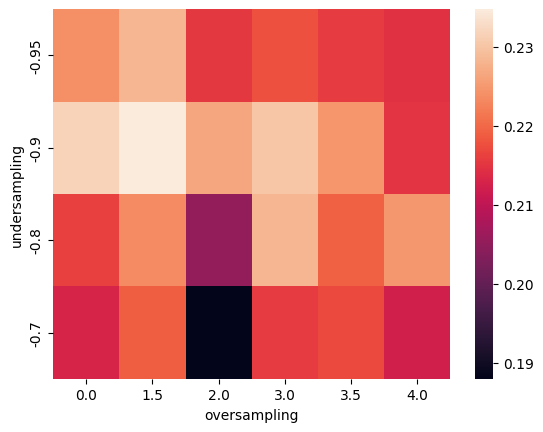

In [ ]:
sns.heatmap(over_under_sampled)

#### Trying different oversample ratios for different classes

In [ ]:
oversample_ratios=[1.5,1.5,1.5,4,4,1.5,2]
under_ratio=0.9
X_undersampled, y_undersampled=undersample(under_ratio)
X_resampled, y_resampled =oversample(k,oversample_ratios)
modelxgboost.fit(X_resampled,y_resampled)
y_pred = modelxgboost.predict(X_test)
f1_scores.loc[len(f1_scores.index)] =[k,under_ratio,"varied"]+f1_score(y_pred,y_test,average=None).tolist()+[calcWeightedf1(y_pred,y_test, weights)]


In [ ]:
f1_scores

,k,undersampling,oversampling,0,1,2,3,4,5,6,7,weighted_f1
0,0.0,-0.50,0.0,0.988932,0.330689,0.300341,0.089762,0.037500,0.000000,0.056075,0.533333,0.196414
1,0.0,-0.70,0.0,0.988037,0.354943,0.335704,0.122078,0.037037,0.000000,0.109091,0.530387,0.212951
2,0.0,-0.80,0.0,0.986506,0.361266,0.331457,0.118881,0.090395,0.000000,0.128000,0.494382,0.216021
3,0.0,-0.90,0.0,0.980949,0.326496,0.301645,0.159677,0.060606,0.000000,0.170213,0.523560,0.231805
4,0.0,-0.95,0.0,0.965748,0.242462,0.239927,0.133705,0.090909,0.038168,0.125000,0.512821,0.223836
5,5.0,-0.70,1.5,0.987720,0.352124,0.336606,0.112676,0.071429,0.000000,0.123894,0.518919,0.218884
6,5.0,-0.70,2.0,0.987696,0.359848,0.321745,0.122807,0.045977,0.000000,0.072072,0.477273,0.188006
7,5.0,-0.70,3.0,0.987410,0.352663,0.337049,0.134161,0.076923,0.025974,0.088496,0.519774,0.215700
8,5.0,-0.70,3.5,0.987503,0.348008,0.333799,0.129743,0.065574,0.026144,0.106195,0.514620,0.216987
9,5.0,-0.70,4.0,0.987395,0.345909,0.320108,0.125908,0.067039,0.000000,0.101695,0.519774,0.212129


In [ ]:
## i decided to use 90% undersampling with 1.5 times oversampling for rarer classes
oversample_ratios=[1.5]*7
k=5
X_undersampled, y_undersampled=undersample(0.9)
X_resampled, y_resampled =oversample(k,oversample_ratios)

In [ ]:
Counter(y_resampled)

Counter({0.0: 66616,
         1.0: 13035,
         2.0: 4455,
         3.0: 3783,
         4.0: 919,
         5.0: 807,
         6.0: 514,
         7.0: 505})

### Embedded (Lasso)

In [ ]:
X=pd.concat([X_resampled,X_test],axis=0)
y=pd.concat([y_resampled,y_test],axis=0)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)


In [ ]:
alpha_range = np.logspace(-5, -2, 5)

In [ ]:
alpha_range

array([1.00000000e-05, 5.62341325e-05, 3.16227766e-04, 1.77827941e-03,
       1.00000000e-02])

In [ ]:
for alpha in alpha_range:
    # Lasso feature selection
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(scaled_X, y)
    selected_features = np.where(lasso_model.coef_ != 0)[0]

    f1s_per_fold = []
    f1_per_label_avg = len(weights)


    modelxgboost.fit(X_resampled[X_resampled.columns[selected_features]],y_resampled)
    y_pred = modelxgboost.predict(X_test[X_test.columns[selected_features]])
    weightedf1=calcWeightedf1(y_pred,y_test, weights)

    selected_features=X_train.columns[selected_features].tolist()
    dropped=set(X.columns)-set(selected_features)
    # Print results in a table format
    print(f"Alpha: {alpha}")
    print(f"Dropped Features:{dropped}")
    print(f"Weighted F1-score: {weightedf1}")
    print("-" * 50)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.398e+04, tolerance: 1.553e+01
  model = cd_fast.enet_coordinate_descent(


Alpha: 1e-05
Dropped Features:{'_Kredi süresi ile uyumlu ', 'ODEMEME_TALEP_ADET', 'HU02', 'BU06'}
Weighted F1-score: 0.23058926141381111
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.404e+04, tolerance: 1.553e+01
  model = cd_fast.enet_coordinate_descent(


Alpha: 5.623413251903491e-05
Dropped Features:{'Taşınan Teminat', 'ODEMEME_TALEP_ADET', 'BU06', 'HU13', 'HU12', 'BU12', '_Uzun Süreli', '_Kredi süresi ile uyumlu ', 'HU02', 'Popularity_by_il', 'HU17'}
Weighted F1-score: 0.23686528184851
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e+04, tolerance: 1.553e+01
  model = cd_fast.enet_coordinate_descent(


Alpha: 0.00031622776601683794
Dropped Features:{'CINSIYET_SEGMENT', 'BU05', 'BU12', 'BILGI_TALEP_ADET', '_Krediden bağımsız', 'HU02', '_Yıllık', 'ODEME_TUTAR_10', 'BES_AYRILMA_TALEP_ADET', 'BU06', 'ODEME_TUTAR_8', 'HU13', 'HU14', 'HU18', 'HU10', '_Tercih doğrultusunda yenilenir', 'HU03', 'ODEME_TUTAR_2', 'ODEMEME_TALEP_ADET', 'BU14', 'PP_UYRUK', 'HU12', 'Negatfi Talep', '_Kredi süresi ile uyumlu ', 'Yaş Gereksinimi', 'HU16', 'Popularity_by_il', 'Taşınan Teminat', 'HAYAT_AYRILMA_TALEP_ADET', 'ODEME_TUTAR_0', 'ODEME_TUTAR_5', 'HU01', '_Koruma '}
Weighted F1-score: 0.2202694816150151
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+03, tolerance: 1.553e+01
  model = cd_fast.enet_coordinate_descent(


Alpha: 0.0017782794100389228
Dropped Features:{'CINSIYET_SEGMENT', 'BU05', 'BU12', 'BILGI_TALEP_ADET', '_Krediden bağımsız', 'HU02', '_Yıllık', 'BU20', 'VADE_TUTAR_8', 'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_7', 'BU18', 'VADE_TUTAR_4', 'BES_AYRILMA_TALEP_ADET', 'BU06', 'ODEME_TUTAR_8', 'HU13', '_hayır', 'VADE_TUTAR_10', 'HU19', 'HU14', 'HU18', 'ODEME_TUTAR_1', 'BU07', 'HU10', '_otomatik Katılım ', '_Tercih doğrultusunda yenilenir', 'HU03', 'ODEME_TUTAR_2', 'ODEMEME_TALEP_ADET', 'BU14', '_Kredi Bağlantılı', 'ODEME_TUTAR_9', 'Ödeme Ortalama', 'PP_UYRUK', 'HU12', 'Negatfi Talep', 'VADE_TUTAR_9', 'Vade Ortalama', '_Bireysel Emeklilik ', 'ODEME_TUTAR_4', '_Kredi süresi ile uyumlu ', 'HU05', 'Yaş Gereksinimi', 'BU10', 'BU21', 'HU16', 'Popularity_by_il', 'Taşınan Teminat', 'HU11', '_Biriktiren', 'BU16', 'ODEME_TUTAR_3', 'HAYAT_AYRILMA_TALEP_ADET', 'BU22', '_Hayat Sigortası ', 'BU04', 'HU01', 'BU03', 'BU15', '_Koruma ', 'HU17'}
Weighted F1-score: 0.2280939772525996
--------------------

In [ ]:
dropped_features=['Taşınan Teminat', 'ODEMEME_TALEP_ADET', 'BU06', 'HU13', 'HU12', 'BU12', '_Uzun Süreli', '_Kredi süresi ile uyumlu ', 'HU02', 'Popularity_by_il', 'HU17']

In [ ]:
X_train=X_resampled.drop(dropped_features,axis=1)
X_test.drop(dropped_features,axis=1,inplace=True)
X.drop(dropped_features,axis=1,inplace=True)
y_train=y_resampled

### Adjusting Thresholds

####Precision Recall Curve

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve
from collections import Counter
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.pyplot as plt

In [ ]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0,1,2,3,4,5,6,7])
n_classes = Y.shape[1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

modelxgboost = XGBClassifier(objective='multi:softmax', num_class=n_classes)
classifier = OneVsRestClassifier(modelxgboost)
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)

In [ ]:
# For each class calculate precision,recall,f1 score, find max f1 score and optimal threshold
precision = dict()
recall = dict()
average_precision = dict()
f1_scores=dict()
ix=dict()
best_threshold=dict()
for i in range(n_classes):
    precision[i], recall[i], thresholds  = precision_recall_curve(Y_test[:, i], y_score[:, i])
    f1_scores[i] =(2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    ix[i] = np.argmax(f1_scores[i])
    best_threshold[i]=thresholds[ix[i]]
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

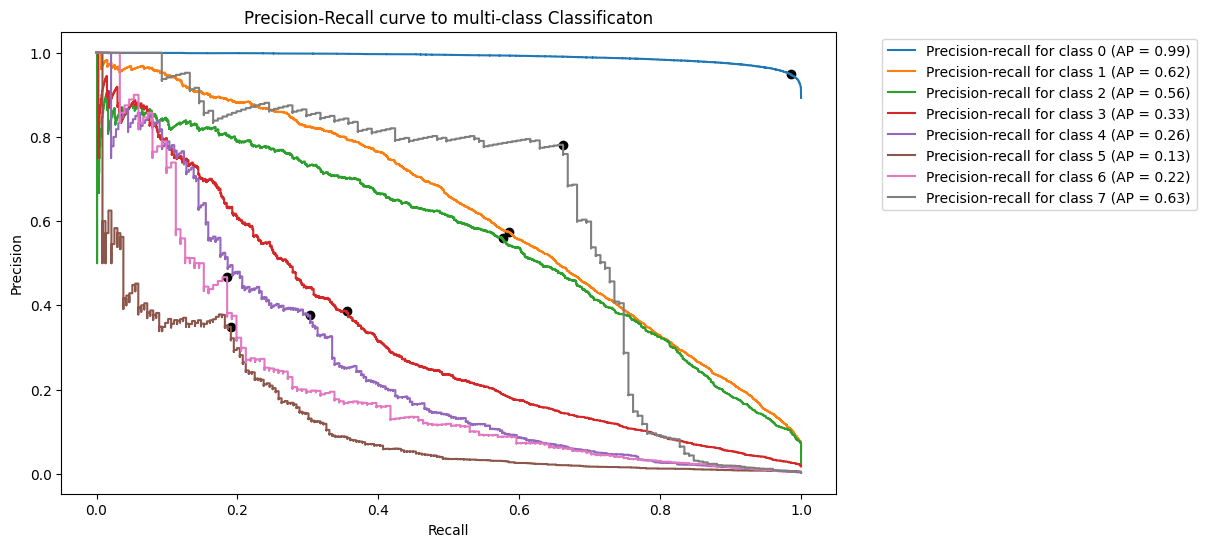

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
f_scores_line = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores_line:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)

#plot all precision recall plots
for i in range(n_classes):
    f1_scores[i] =(2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    ix[i] = np.argmax(f1_scores[i])
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}")
    plt.scatter(recall[i][ix[i]], precision[i][ix[i]], marker='o', color='black')

# set the legend and the axes
handles, labels = display.ax_.get_legend_handles_labels()
ax.legend(handles=handles,labels=labels,bbox_to_anchor=(1.05, 1),loc='upper left')
ax.set_title("Precision-Recall curve to multi-class Classificaton")

plt.show()

In [ ]:
best_threshold

[0.5298093,
 0.25514704,
 0.29521048,
 0.1719623,
 0.11585019,
 0.14829528,
 0.20721927,
 0.12020154]

### Trying Different Thresholds

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
modelxgboost.fit(X_train,y_train)
y_pred=modelxgboost.predict(X_test)
y_pred_proba = modelxgboost.predict_proba(X_test)

In [ ]:
f1scores_threholds=pd.DataFrame(columns=["name",0,1,2,3,4,5,6,7,"weighted_f1"])
f1scores_threholds.loc[len(f1scores_threholds.index)] =["no name"]+f1_score(y_pred,y_test,average=None).tolist()+[calcWeightedf1(y_pred,y_test, weights)]

In [ ]:
Probability_Results=pd.DataFrame(y_pred_proba)*100
#Probability_Results.drop("Unnamed: 0",axis=1,inplace=True)
Probability_Results["Pred"]=y_pred
Probability_Results["Real Value"]=y_test.values
false_results=Probability_Results[Probability_Results["Pred"]!=Probability_Results["Real Value"]]
false_results["Real Value"].value_counts()

Real Value
0.0    4912
1.0    1092
3.0     564
2.0     409
5.0     136
4.0     136
6.0      88
7.0      27
Name: count, dtype: int64

Examine the probabilities for different false classifications

In [ ]:
false_results[false_results["Real Value"]==7]

,0,1,2,3,4,5,6,7,Pred,Real Value
3291,60.932594,35.217197,0.002208,3.375874,0.272089,0.074190,0.036070,0.089780,0.0,7.0
7375,51.534290,11.165709,0.000729,2.109725,2.533576,0.750014,0.007035,31.898924,0.0,7.0
13438,45.114933,24.544706,9.199187,4.601510,1.495972,5.726454,0.125021,9.192222,0.0,7.0
38212,55.532867,5.088551,24.234327,14.406077,0.082939,0.074012,0.558295,0.022933,0.0,7.0
46049,7.139823,19.373543,70.047720,0.348516,2.578034,0.081818,0.008110,0.422438,2.0,7.0


In [ ]:
false_results[false_results["Real Value"]==3]

,0,1,2,3,4,5,6,7,Pred,Real Value
28,92.895850,2.982607,0.295669,3.176663,0.184753,0.020048,0.058994,0.385409,0.0,3.0
906,45.923020,14.856807,0.002235,34.911720,1.583729,0.935754,1.718261,0.068479,0.0,3.0
1176,73.484130,19.751633,0.001720,2.438051,2.501148,1.236962,0.582858,0.003490,0.0,3.0
1584,49.234543,4.947038,1.546853,22.449593,21.297020,0.468833,0.042182,0.013936,0.0,3.0
1608,14.624856,28.835302,0.003800,21.127813,19.256424,0.936768,15.184845,0.030190,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
49868,56.737823,6.929904,9.689671,20.521528,1.975710,3.916597,0.023536,0.205232,0.0,3.0
49955,78.111070,0.028084,0.013740,21.804377,0.019989,0.009504,0.004692,0.008548,0.0,3.0
51209,75.313480,4.397860,12.060433,6.452786,1.538328,0.060371,0.103956,0.072792,0.0,3.0
51580,65.237640,26.964802,0.002032,4.056639,1.103974,1.938723,0.679467,0.016720,0.0,3.0


class 0 has really high likelyhood i will not put any threshold on it, for classes 4,5,6,7 we can try lower thresholds (%10-%20) for 1,2,3 claases we can try slightlyhigher thresholds(%20-%30)

In [ ]:
def try_threshold(thresholds,threshold_name):
  Probability_Results[threshold_name]=Probability_Results["Pred"]
  for class_num in np.arange(1,8):
    Probability_Results.loc[Probability_Results[class_num] > thresholds[class_num]*100, threshold_name] = class_num
  row=[threshold_name]+f1_score(Probability_Results[threshold_name],y_test,average=None).tolist()+[calcWeightedf1(Probability_Results[threshold_name],y_test, weights)]
  f1scores_threholds.loc[len(f1scores_threholds.index)] =row


In [ ]:
try_threshold([0.5,0.3,0.3,0.3,0.2,0.2,0.2,0.2],"threshold_1")
try_threshold([0,5,0.25,0.25,0.25,0.15,0.15,0.15,0.15],"threshold_2")
try_threshold([0,5,0.2,0.2,0.2,0.1,0.1,0.1,0.1],"threshold_3")
try_threshold([0,5,0.5,0.5,0.5,0.5,0.5,0.2,0.2],"threshold_4")

In [ ]:
#i decided to apply threshold_1

### Tuning

In [ ]:
from hyperopt import hp, fmin, tpe
from hyperopt.fmin import fmin
import xgboost as xgb

In [ ]:
def objective_function(params):
  model = XGBClassifier(
      objective='multi:softmax',
      learning_rate=params['learning_rate'],
      n_estimators=int(params['n_estimators']),
      max_depth=int(params['max_depth']),
      min_child_weight=int(params['min_child_weight']),
      gamma=params['gamma'],
      subsample=params['subsample'],
      colsample_bytree=params['colsample_bytree'])
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  dtrain = xgb.DMatrix(X_test, label=y_test)
  custom_score = weighted_f1_score(preds, dtrain)
  return -custom_score # Minimize negative F1 score (maximize F1 score)


In [ ]:
search_space = {
  'learning_rate': hp.loguniform('learning_rate', -3, 0),  # Search on log scale
  'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),  # Integer values in steps of 100
  'max_depth': hp.quniform('max_depth', 3, 10, 1),  # Integer values in steps of 1
  'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),  # Integer values in steps of 1
  'gamma': hp.uniform('gamma', 0, 5),
  'subsample': hp.uniform('subsample', 0.5, 1),
  'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

In [ ]:
best_params = fmin(fn=objective_function,
                space=search_space,
                max_evals=25,
                algo=tpe.suggest)

In [ ]:
best_params

In [ ]:
best_model = XGBClassifier(
    objective='multi:softmax',
    **best_params)